# Summarization use Fine Tuned T5 Transformer

## Install Library

https://huggingface.co/

In [1]:
# !pip install -U transformers
# !pip install -U accelerate
!pip install -U datasets
# !pip install -U bertviz
# !pip install -U umap-learn
# !pip install -U sentencepiece
# !pip install -U urllib3
!pip install py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 whi

### Fine-Tuning Summarization Model on Custom Dataset

https://huggingface.co/datasets/samsum

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from datasets import load_dataset

samsum = load_dataset("samsum", trust_remote_code=True)

README.md:   0%|          | 0.00/7.04k [00:00<?, ?B/s]

samsum.py:   0%|          | 0.00/3.36k [00:00<?, ?B/s]

corpus.7z:   0%|          | 0.00/2.94M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

In [5]:
samsum['train'][0]

{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}

In [6]:
dialogue_len = [len(x['dialogue'].split()) for x in samsum['train']]
summary_len = [len(x['summary'].split()) for x in samsum['train']]

array([[<Axes: title={'center': 'Dialogue Length'}>,
        <Axes: title={'center': 'Summary Length'}>]], dtype=object)

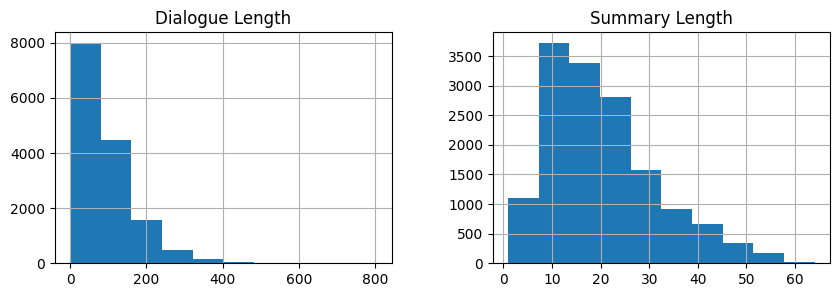

In [7]:
import pandas as pd

data = pd.DataFrame([dialogue_len, summary_len]).T
data.columns = ['Dialogue Length', 'Summary Length']

data.hist(figsize=(10,3))

## Model Loading and Tokenization

In [9]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ckpt = 't5-small'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [10]:
samsum['train'][0]

{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}

In [11]:
tokenizer(samsum['train'][0]['dialogue'], text_target=samsum['train'][0]['summary'], return_tensors='pt')

{'input_ids': tensor([[21542,    10,    27, 13635,  5081,     5,   531,    25,   241,   128,
            58, 16637,    10, 10625,    55, 21542,    10,    27,    31,   195,
           830,    25,  5721,     3,    10,    18,    61,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'labels': tensor([[21542, 13635,  5081,    11,    56,   830, 16637,   128,  5721,     5,
             1]])}

In [12]:
def tokenize(batch):
    encoding = tokenizer(batch['dialogue'], text_target=batch['summary'], max_length=200, truncation=True, padding=True, return_tensors='pt')

    return encoding

In [13]:
samsum_pt = samsum.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [14]:
samsum_pt

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

## Model Training

In [19]:
from transformers import DataCollatorForSeq2Seq
from transformers import TrainingArguments, Trainer

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

args = TrainingArguments(
    output_dir="train_dir",
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    eval_strategy='epoch',
    save_strategy='epoch',
    weight_decay=0.01,
    learning_rate=2e-5,
    gradient_accumulation_steps=500
)

trainer = Trainer(model=model,
                  args=args,
                  tokenizer=tokenizer,
                  data_collator=data_collator,
                  train_dataset=samsum_pt['train'],
                  eval_dataset=samsum_pt['validation']
                  )

import os
os.environ["WANDB_DISABLED"] = "true"
trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,No log,13.829119


TrainOutput(global_step=14, training_loss=13.466947283063616, metrics={'train_runtime': 606.2458, 'train_samples_per_second': 48.601, 'train_steps_per_second': 0.023, 'total_flos': 1413264467558400.0, 'train_loss': 13.466947283063616, 'epoch': 1.8145533532446376})

In [20]:
trainer.save_model("t5_samsum_summarization")

## Prediction

In [21]:
from transformers import pipeline

In [24]:
pipe = pipeline('summarization', model='t5_samsum_summarization', device=device)

custom_dialogue="""
Syahmi: what work you planning to give Tom?
Putri: i was hoping to send him on a business trip first.
Syahmi: cool. is there any suitable work for him?
Putri: he did excellent in last quarter. i will assign new project, once he is back.
"""

output = pipe(custom_dialogue)
output

Device set to use cuda
Your max_length is set to 200, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


[{'summary_text': 'i was hoping to send him on a business trip first . i will assign new project, once he is back .'}]